This notebook is used to perform survival analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, plotting, CoxPHFitter, NelsonAalenFitter
from IPython.display import display

plt.style.use('bmh')
mpl.rcParams.update({
    "grid.linestyle" : "dashed",
    "axes.facecolor" : "white",
    "axes.spines.top" : False,
    "axes.spines.right" : False,
    "legend.frameon" : True,
    "figure.figsize" : (8, 5),
    "figure.dpi" : 500,
})

%matplotlib inline

In [2]:
# TODO make test for dataset with creatina column
# Dataset without thyroid = 18 features (including survive7y)
# Dataset with thyroid = 27 features (including survive7y)
# With columns that have missing values, 23 and 32
# Default 18
n_features = 27
extra_path = n_features != 27 and n_features != 18
dropped_na_key = "dropped_na/"
mean_key = "mean/"
key = dropped_na_key
path = f"data/{n_features}features/{key if extra_path else '' }"
path_models = f"models/{n_features}features/{key if extra_path else '' }"
path_images = f"figures/kaplan_meier_comparision/"
print(path_models)
print(path)
print(path_images)

models/27features/
data/27features/
figures/kaplan_meier_comparision/


In [3]:
# Load the dataset and the extra data
df = pd.read_csv(f"data/raw/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%Y/%m/%d")
df["Data prelievo"] = pd.to_datetime(df["Data prelievo"], format="%Y/%m/%d")

# Create and add target feature `Survive`
df_diff = (df["Follow Up Data"] - df["Data prelievo"]).map(lambda x: x.days // 365)
years = 7
survive = (df_diff < years) & df["CVD Death"]
survive = (survive + 1) % 2
df[f"Survive{years}Y"] = survive

df["Death7Y"] = df["Survive7Y"].map(lambda x: (x+1)%2)
#display(df)

<AxesSubplot:>

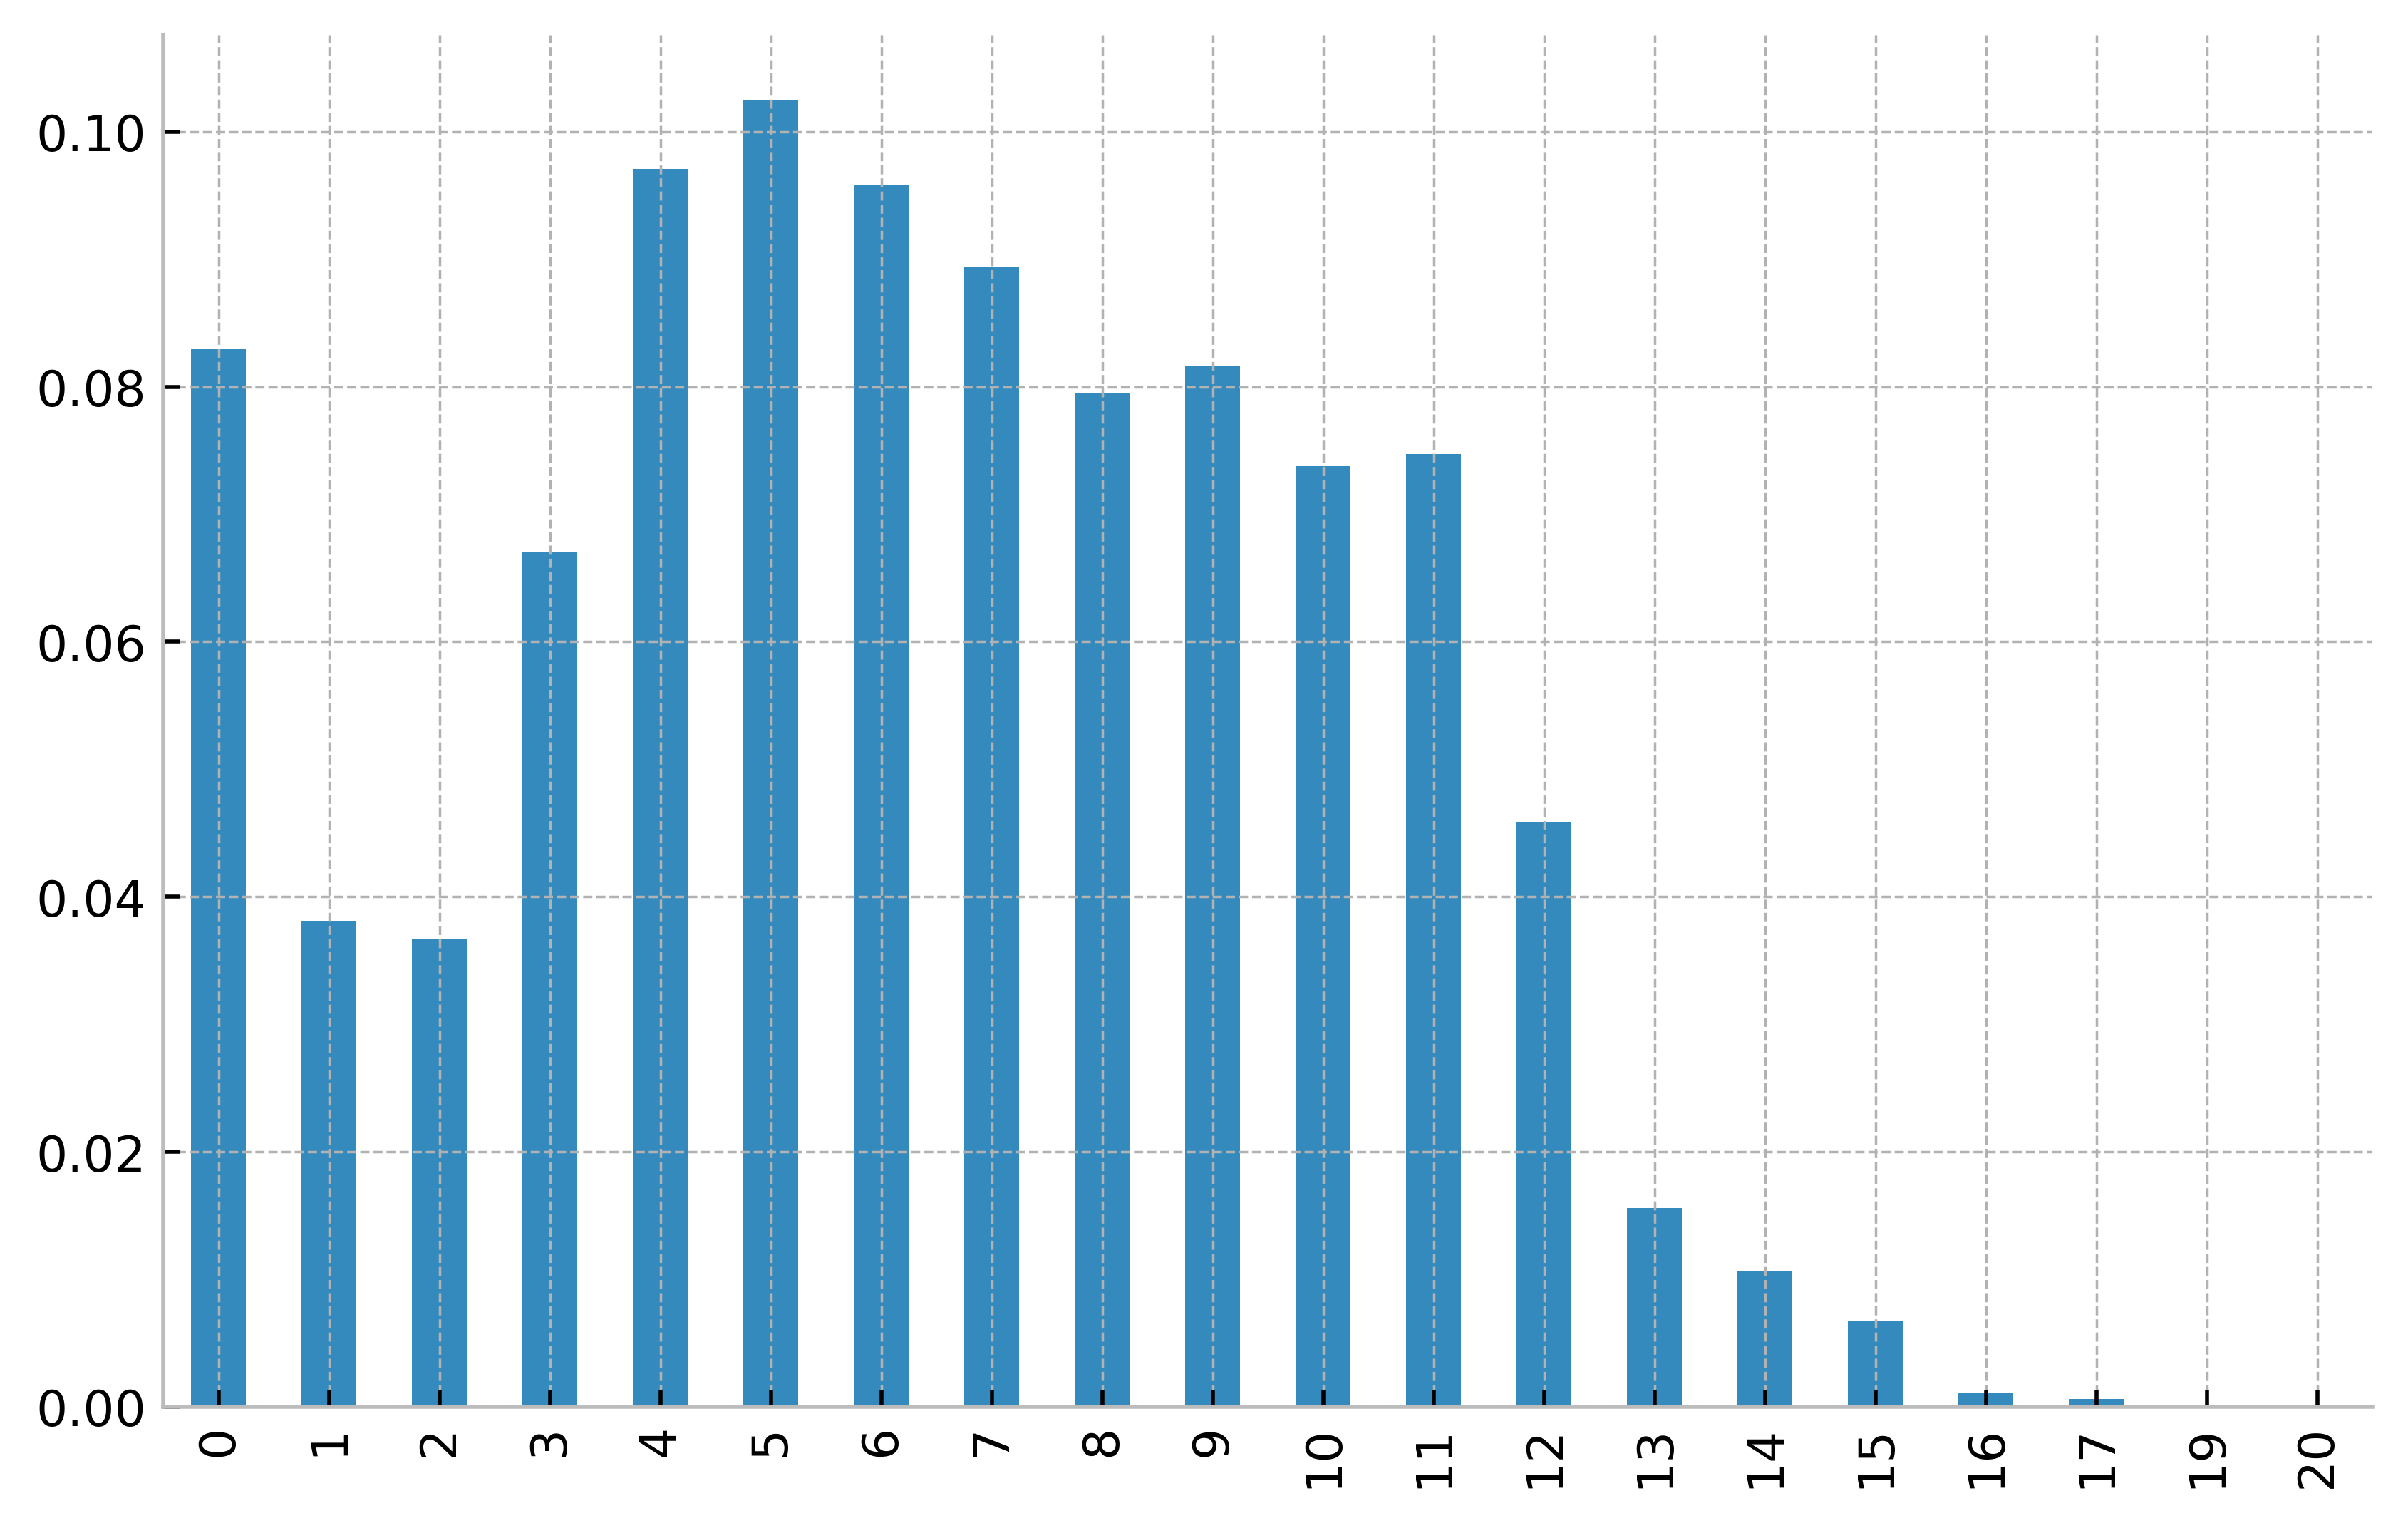

In [4]:
# Birth event: "Data prelievo"
# Death event: "Death7Y"

# Duration and observation features
df_surv = pd.DataFrame()
df_surv["Death7Y"] = df["Death7Y"]
df_surv["duration"] = df_diff
df_surv["observed"] = df["CVD Death"]
df_surv["ID"] = np.random.randint(0, 1e6, size=len(df_surv))
#display(df_surv)
# Plot duration
df_surv["duration"].value_counts(normalize=True).sort_index().plot(kind='bar')
# df_surv.to_csv("data/data_surv.csv")

<AxesSubplot:>

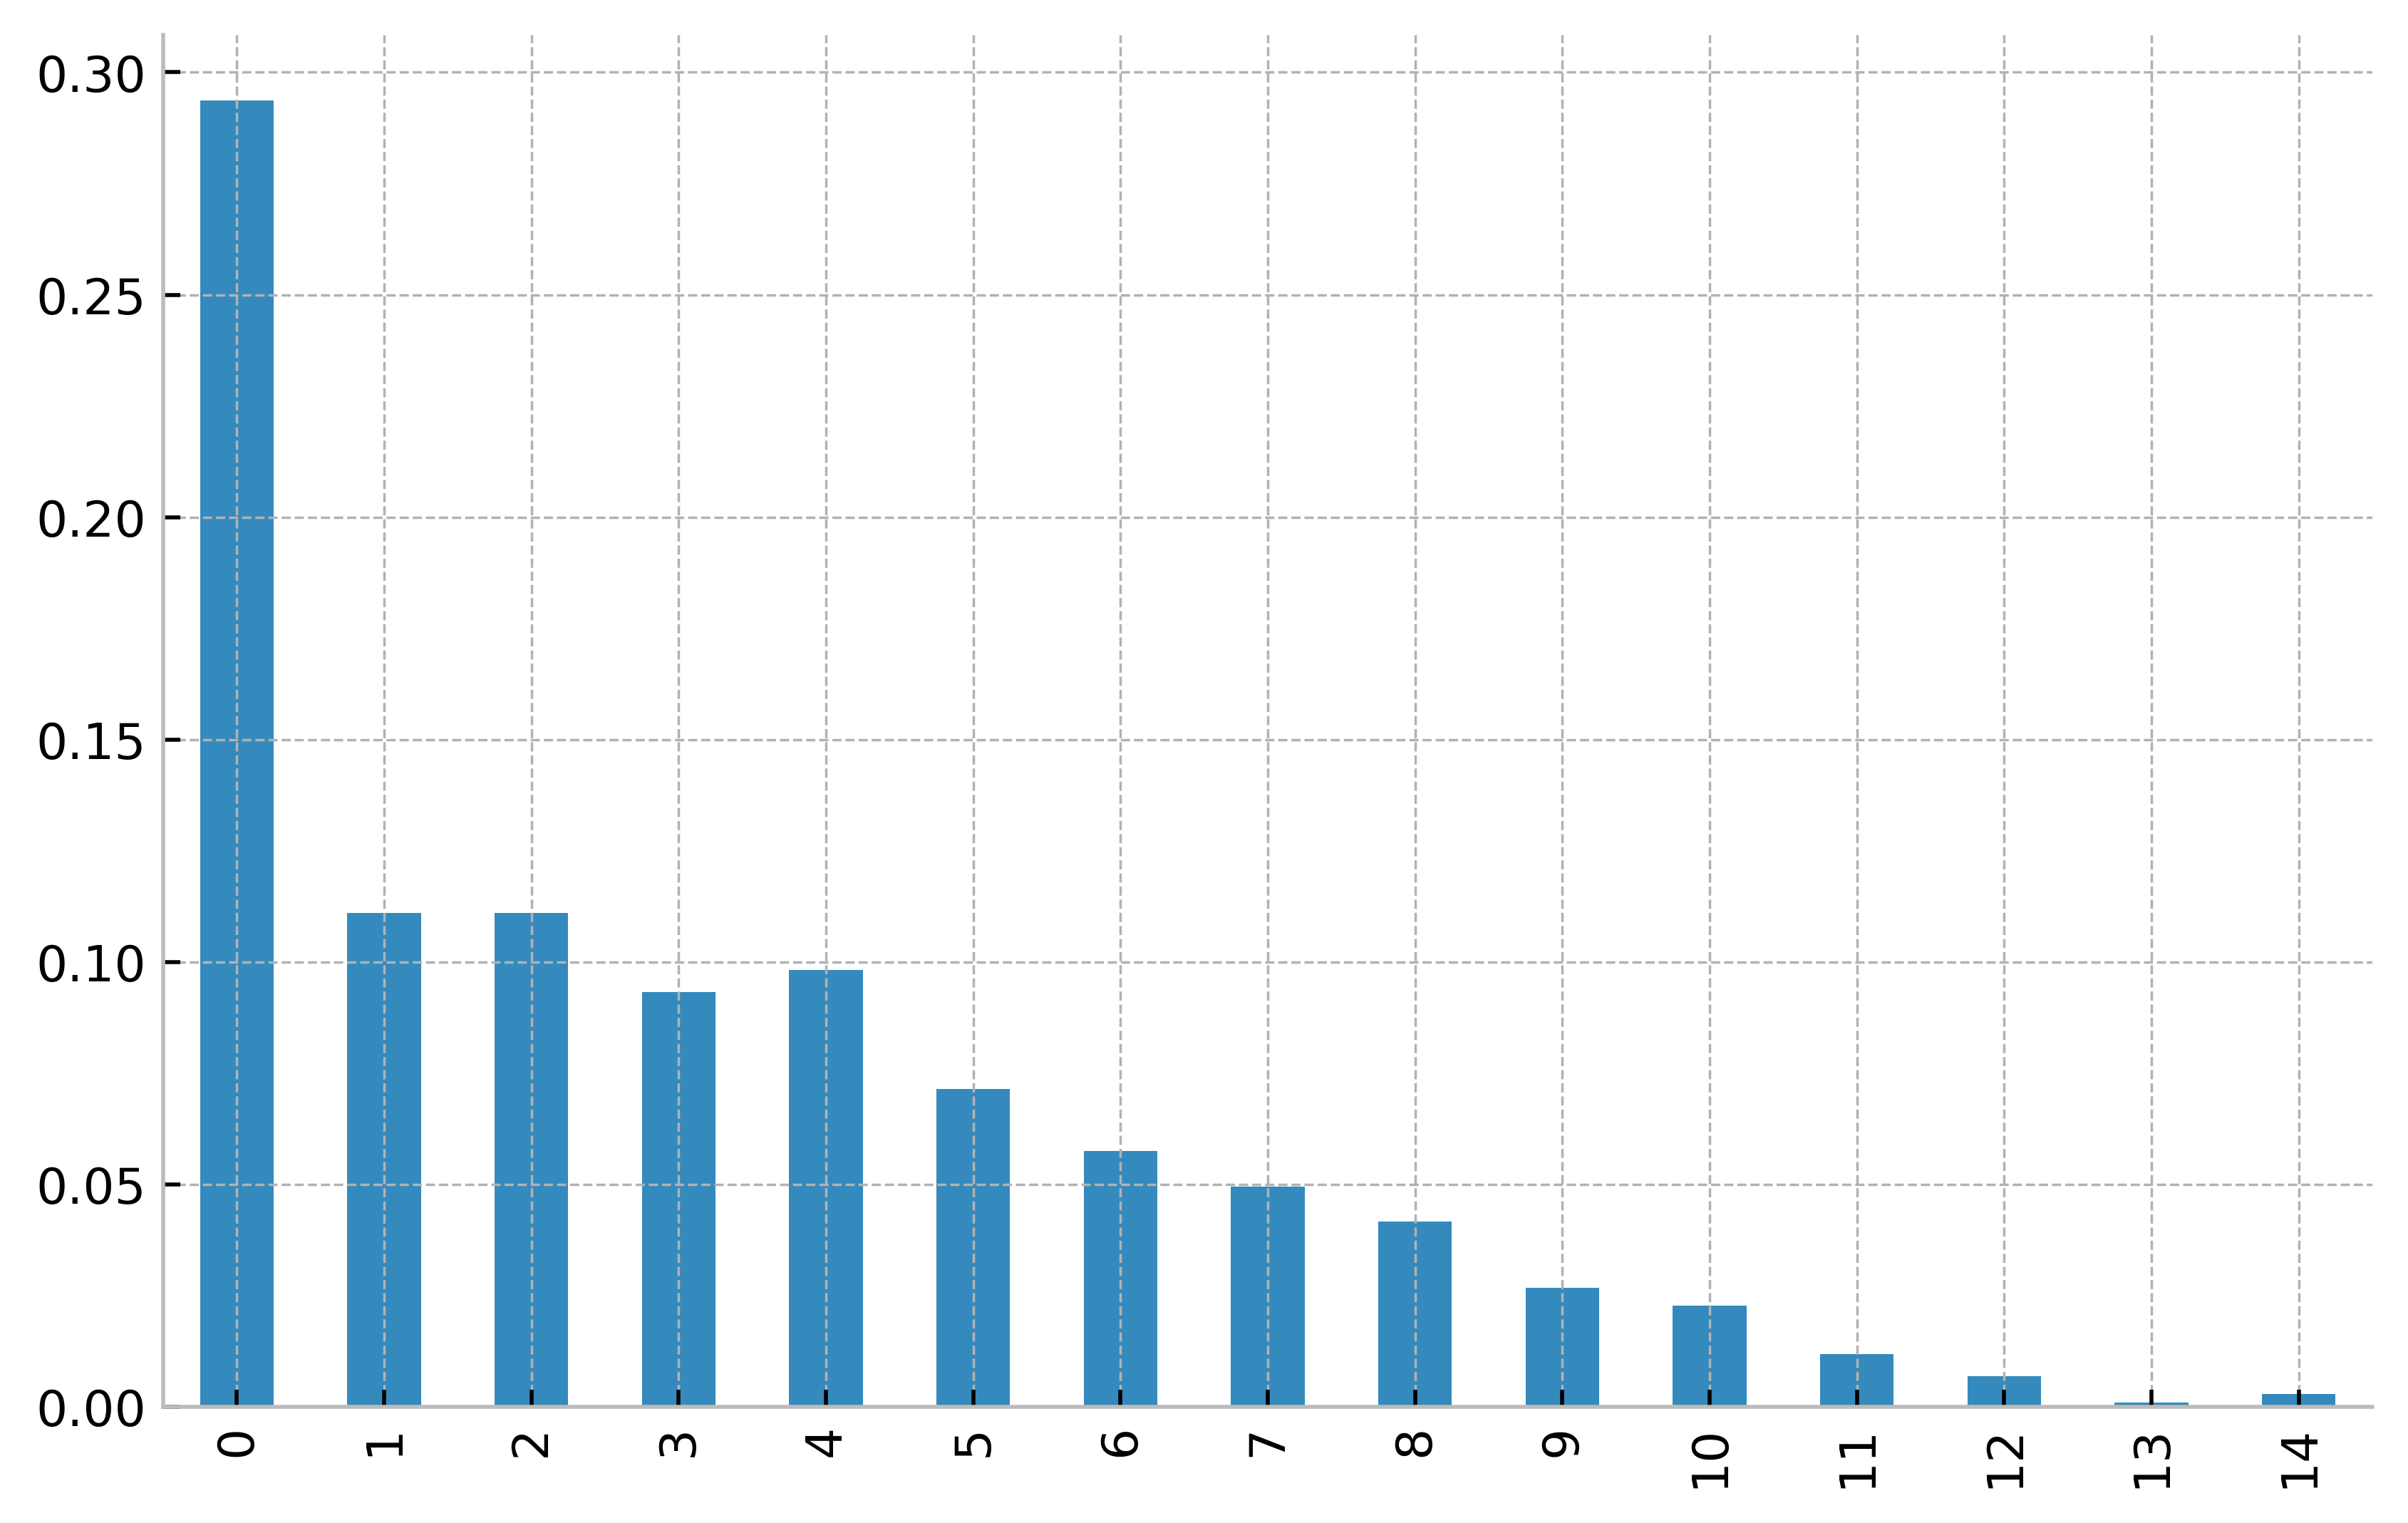

In [5]:
# Data without Right-censoring
#pd.set_option('display.max_rows', 7000)
#display(df_surv[df_surv["observed"]==1])
df_surv[df_surv["observed"]==1]["duration"].value_counts(normalize=True).sort_index().plot(kind='bar')

### Survival Analysis on all the data
The plot indicates the % of CVD patients that survived after n years. 
The probability for surviving more than 7 years is ~86%.

<AxesSubplot:title={'center':'Survival Function of CVD Patients without Right-Censoring'}, xlabel='Years', ylabel='Survive7Y'>

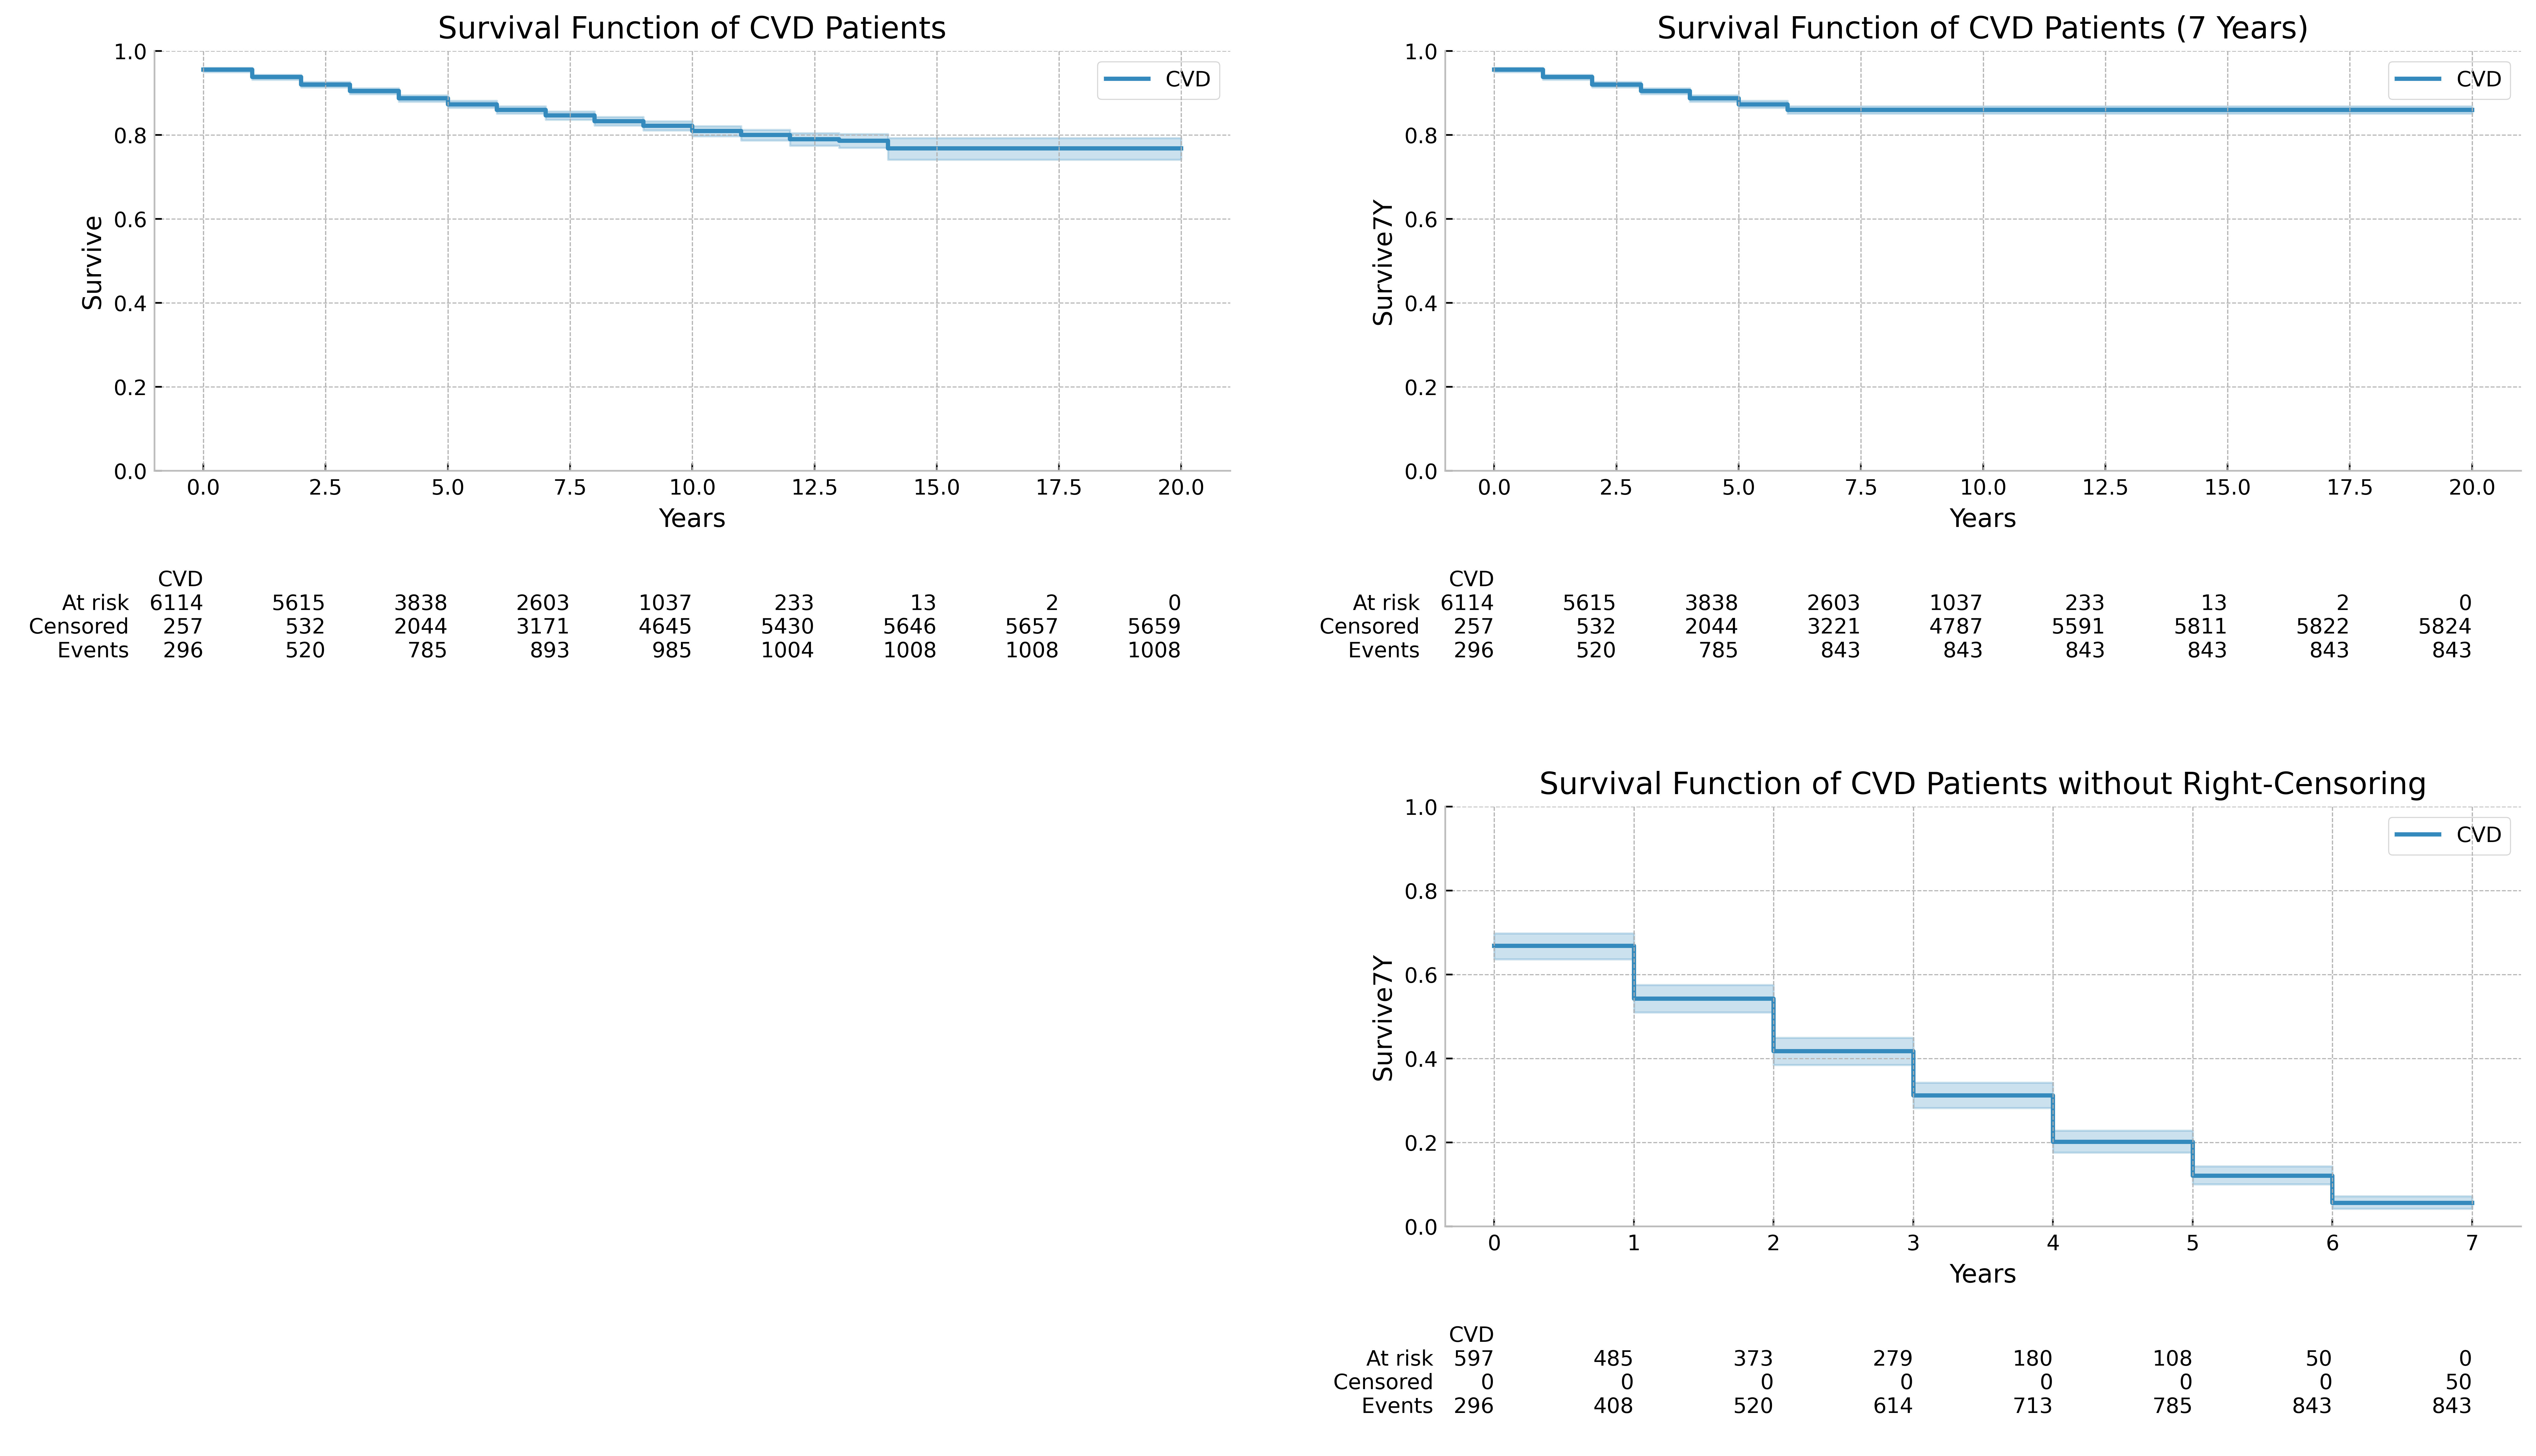

In [6]:
fig = plt.figure(figsize=(20, 10), dpi=500) 
fig_dims = (2, 2)
fig.subplots_adjust(hspace=0.8, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
kmf1 = KaplanMeierFitter()
kmf1.fit(df_surv["duration"], event_observed=df_surv["observed"], label="CVD")
kmf1.plot_survival_function()
plt.title('Survival Function of CVD Patients')
plt.xlabel("Years")
plt.ylabel("Survive")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf1)
#display(kmf1.survival_function_at_times(df_surv["duration"].unique()))

plt.subplot2grid(fig_dims, (0, 1))
kmf2 = KaplanMeierFitter()
kmf2.fit(df_surv["duration"], event_observed=df_surv["Death7Y"], label="CVD")
kmf2.plot_survival_function()
plt.title('Survival Function of CVD Patients (7 Years)')
plt.xlabel("Years")
plt.ylabel("Survive7Y")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf2)
#display(kmf2.survival_function_at_times(df_surv["duration"].unique()))


# Without right-censoring
df = df_surv[df_surv["observed"]==1]
df = df[df["duration"]<=7]
plt.subplot2grid(fig_dims, (1, 1))
kmf2 = KaplanMeierFitter()
kmf2.fit(df["duration"], event_observed=df["Death7Y"], label="CVD")
kmf2.plot_survival_function()
plt.title('Survival Function of CVD Patients without Right-Censoring')
plt.xlabel("Years")
plt.ylabel("Survive7Y")
plt.ylim(0, 1)
plotting.add_at_risk_counts(kmf2)

# plt.savefig("")
# kmf.median_survival_time_
# kmf.confidence_interval_

### Survival Analysis Univariate

In [7]:
# Load the dataset and the extra data
df = pd.read_csv(f"data/raw/data_cvd.csv", index_col=0, decimal='.')
df["Follow Up Data"] = pd.to_datetime(df["Follow Up Data"], format="%Y/%m/%d")
df["Data prelievo"] = pd.to_datetime(df["Data prelievo"], format="%Y/%m/%d")

# Create and add target feature `Survive`
df_diff = (df["Follow Up Data"] - df["Data prelievo"]).map(lambda x: x.days // 365)
years = 7
survive = (df_diff < years) & df["CVD Death"]
survive = (survive + 1) % 2
df[f"Survive{years}Y"] = survive

df["Death7Y"] = df["Survive7Y"].map(lambda x: (x+1)%2)
df["duration"] = df_diff
df["observed"] = df["CVD Death"]

# Remove columns that were not found within the old dataset
to_drop = ['Glycemia', 'Primary Dilated\nCardiomyopathy', 'Normal', 'SindromeX', 'AMI', 'PMI', 'Aritmie', 'MIN', 'MIO', 'Miocardite', 'Pericardite', 'Endocardite', 'Valvulopatie', 'MalattiaVasoAorta', 'Ipertensione', 'CardiopatiaCongenita', 'EmboliaPolmonare', 'EPA', 'HR', 'Weight', 'Height', 'BMI', 'Diastolic blood pressure', 'Systolic blood pressure', 'WmsiBas', 'DimSettoIV', 'DimPP', 'vsx', 'B-Blockers', 'Amiodarone', 'Calcium channel blockers', 'Diuretics', 'Antiplatelet', 'Nitrates', 'ACE-inhibitors', 'Ipolipemizzanti', 'Antidiabetici', 'Cause of death', 'Collected by', 'Suicide', 'CABG ', 'Non Fatal AMI (Follow-Up)', 'Ictus', 'PCI']

#Columns with missing values
drop_columns_missing = ['Total cholesterol', 'HDL', 'LDL', 'Triglycerides', 'Creatinina']

# Not useful columns
nu_columns = ["Data of death", "Data prelievo", "Follow Up Data",
                                "Fatal MI or Sudden death", "UnKnown", "Accident", "Total mortality", 
                                "CVD Death", "CAD"]
df = df.drop(columns = to_drop + drop_columns_missing + nu_columns)
print(len(df.columns)) 
assert len(df.columns) == 30
#display(df)

30


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


30
0 Gender (Male = 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


1 Age


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


2 TSH


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


3 fT3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


4 fT4


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


5 Euthyroid


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


6 Subclinical primary hypothyroidism (SCH)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


7 Subclinical primary hyperthyroidism
(SCT)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


8 Low T3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


9 Ipotiroidismo


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


10 Ipertiroidismo


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


11 Angina


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


12 Previous CABG


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


13 Previous PCI


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


14 Previous Myocardial Infarction


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


15 Acute Myocardial Infarction


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


16 Angiography


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


17 Vessels


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


18 Documented resting 
or exertional ischemia


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


19 Post-ischemic Dilated
Cardiomyopathy


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


20 Smoke
History of smoke


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


21 Diabetes
History of diabetes


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


22 Hypertension
History of hypertension


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


23 Dyslipidemia
Hystory of dyslipidemia


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


24 Atrial Fibrillation


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


25 fe


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


27 Death7Y


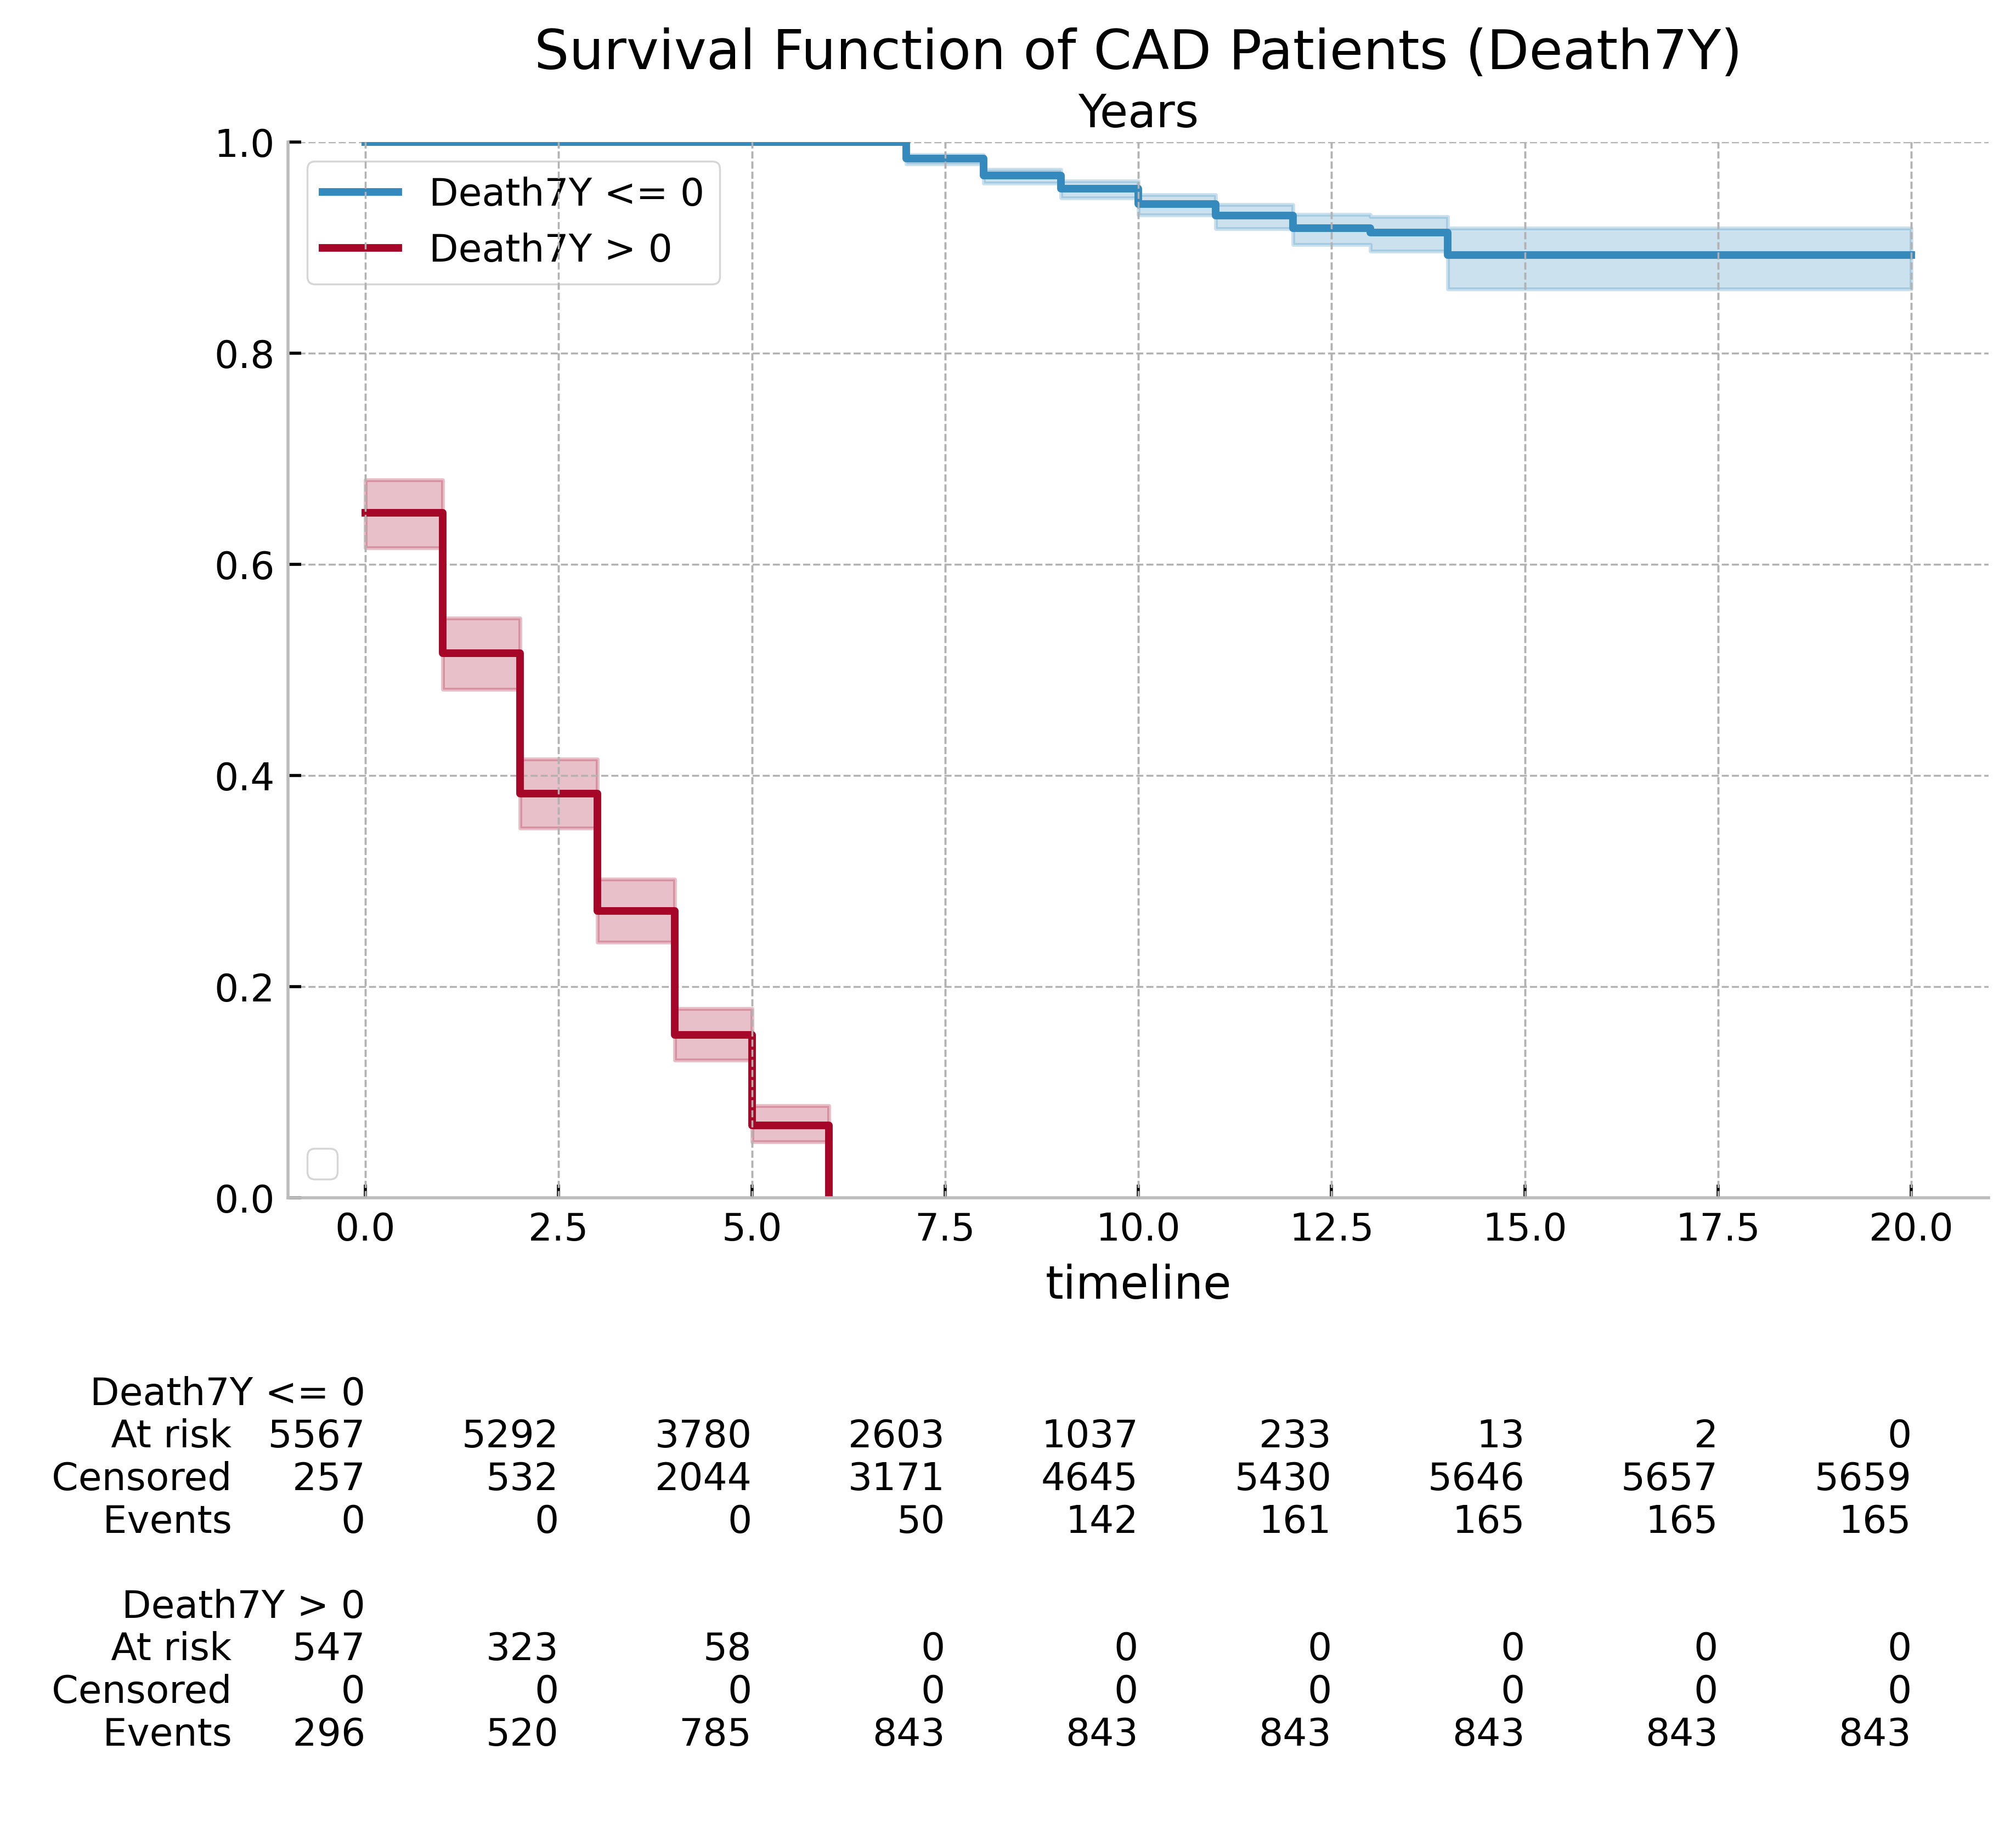

In [10]:
#fig = plt.figure(figsize=(12, 10.5), dpi=400) 
from contextlib import redirect_stdout
df = df.select_dtypes(exclude=['object','datetime64'])
columns = df.columns
print(len(columns))
#fig, axes = plt.subplots(nrows = len(columns), ncols = 1, figsize = (12, 10.5))
#fig_dims = (len(columns), 1)
#fig.subplots_adjust(hspace=1.80, wspace=0.20)
#print(df.info())
for value in enumerate(columns):
    if value[1] == "duration" or value[1] == "observed" or value[1] == "Survive7Y":
        continue
    print(value[0], value[1])
    #plt.subplot2grid(fig_dims, (idx, 0))
    mean = df[value[1]].mean()
    df_under_mean = df[df[value[1]] <= mean]
    df_above_mean = df[df[value[1]] > mean]
    if len(df_under_mean) == 0 or len(df_above_mean) == 0:
        continue
    plt.clf()
    kmf1 = KaplanMeierFitter()
    kmf1.fit(df_under_mean["duration"], event_observed=df_under_mean["observed"], label=f"{value[1]} <= {int(mean)}")
    kmf1.plot_survival_function()
    kmf2 = KaplanMeierFitter()
    kmf2.fit(df_above_mean["duration"], event_observed=df_above_mean["observed"], label=f"{value[1]} > {int(mean)}")
    ax = kmf2.plot_survival_function()
    plotting.add_at_risk_counts(kmf1, kmf2)
    plt.title(f'Survival Function of CAD Patients ({value[1]})')
    plt.xlabel("Years")
    plt.ylabel("Survivals")
    plt.ylim(0, 1)
    plt.legend(loc="lower left")
    ax.get_figure().savefig(f"{path_images}{value[1]}.png")

### Survival Analysis Model 

In [8]:
def plot_kmf(df_pred, threshold, variable):
    df_pred_under = df_pred[df_pred["ModelOutput"] <= threshold]
    df_pred_above = df_pred[df_pred["ModelOutput"] > threshold]

    kmf1 = KaplanMeierFitter()
    kmf1.fit(df_pred_under["duration"], event_observed=df_pred_under["observed"], label=f"<= {threshold}")
    kmf1.plot_survival_function()
    print(kmf1.survival_function_)

    kmf2 = KaplanMeierFitter()
    kmf2.fit(df_pred_above["duration"], event_observed=df_pred_above["observed"], label=f"> {threshold}")
    kmf2.plot_survival_function(linestyle="--")
    print(kmf2.survival_function_)

    plt.title(f'Survival Function of IHD Patients ({variable})')
    plt.xlabel("Years")
    plt.ylabel("Survivals")


    plt.ylim(0, 1)
    plotting.add_at_risk_counts(kmf1, kmf2)

## Plot the survival function for patients under and over the threshold of the ModelOutput

In [9]:
df_out = pd.read_csv(f"{path}extra_test_output.csv", index_col=0, decimal='.')
# Model 27 features
# Drop rows that are not in test set
df_test_pred = df_surv.drop(list(set(df_surv.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)
display(df_test_pred)

,Death7Y,duration,observed,ID,ModelOutput
Number,,,,,
2,0,2,0,989996,0.947342
5,1,3,1,410457,0.470484
18,1,2,1,646063,0.341522
23,0,3,0,284669,0.547367
31,0,8,1,950515,0.569832
...,...,...,...,...,...
8043,0,2,0,566925,0.994635
8045,0,1,0,580069,0.541091
8046,0,3,0,516874,0.915154


            <= 0.6
timeline          
0.0       0.766871
1.0       0.683793
2.0       0.604894
3.0       0.510800
4.0       0.418572
5.0       0.343229
6.0       0.287570
7.0       0.255618
8.0       0.210509
9.0       0.210509
10.0      0.210509
11.0      0.210509
12.0      0.210509
13.0      0.210509
             > 0.6
timeline          
0.0       0.983775
1.0       0.977565
2.0       0.965787
3.0       0.954546
4.0       0.949533
5.0       0.943881
6.0       0.939915
7.0       0.927628
8.0       0.922182
9.0       0.913074
10.0      0.903429
11.0      0.893221
12.0      0.893221
13.0      0.893221
14.0      0.893221
15.0      0.893221
16.0      0.893221


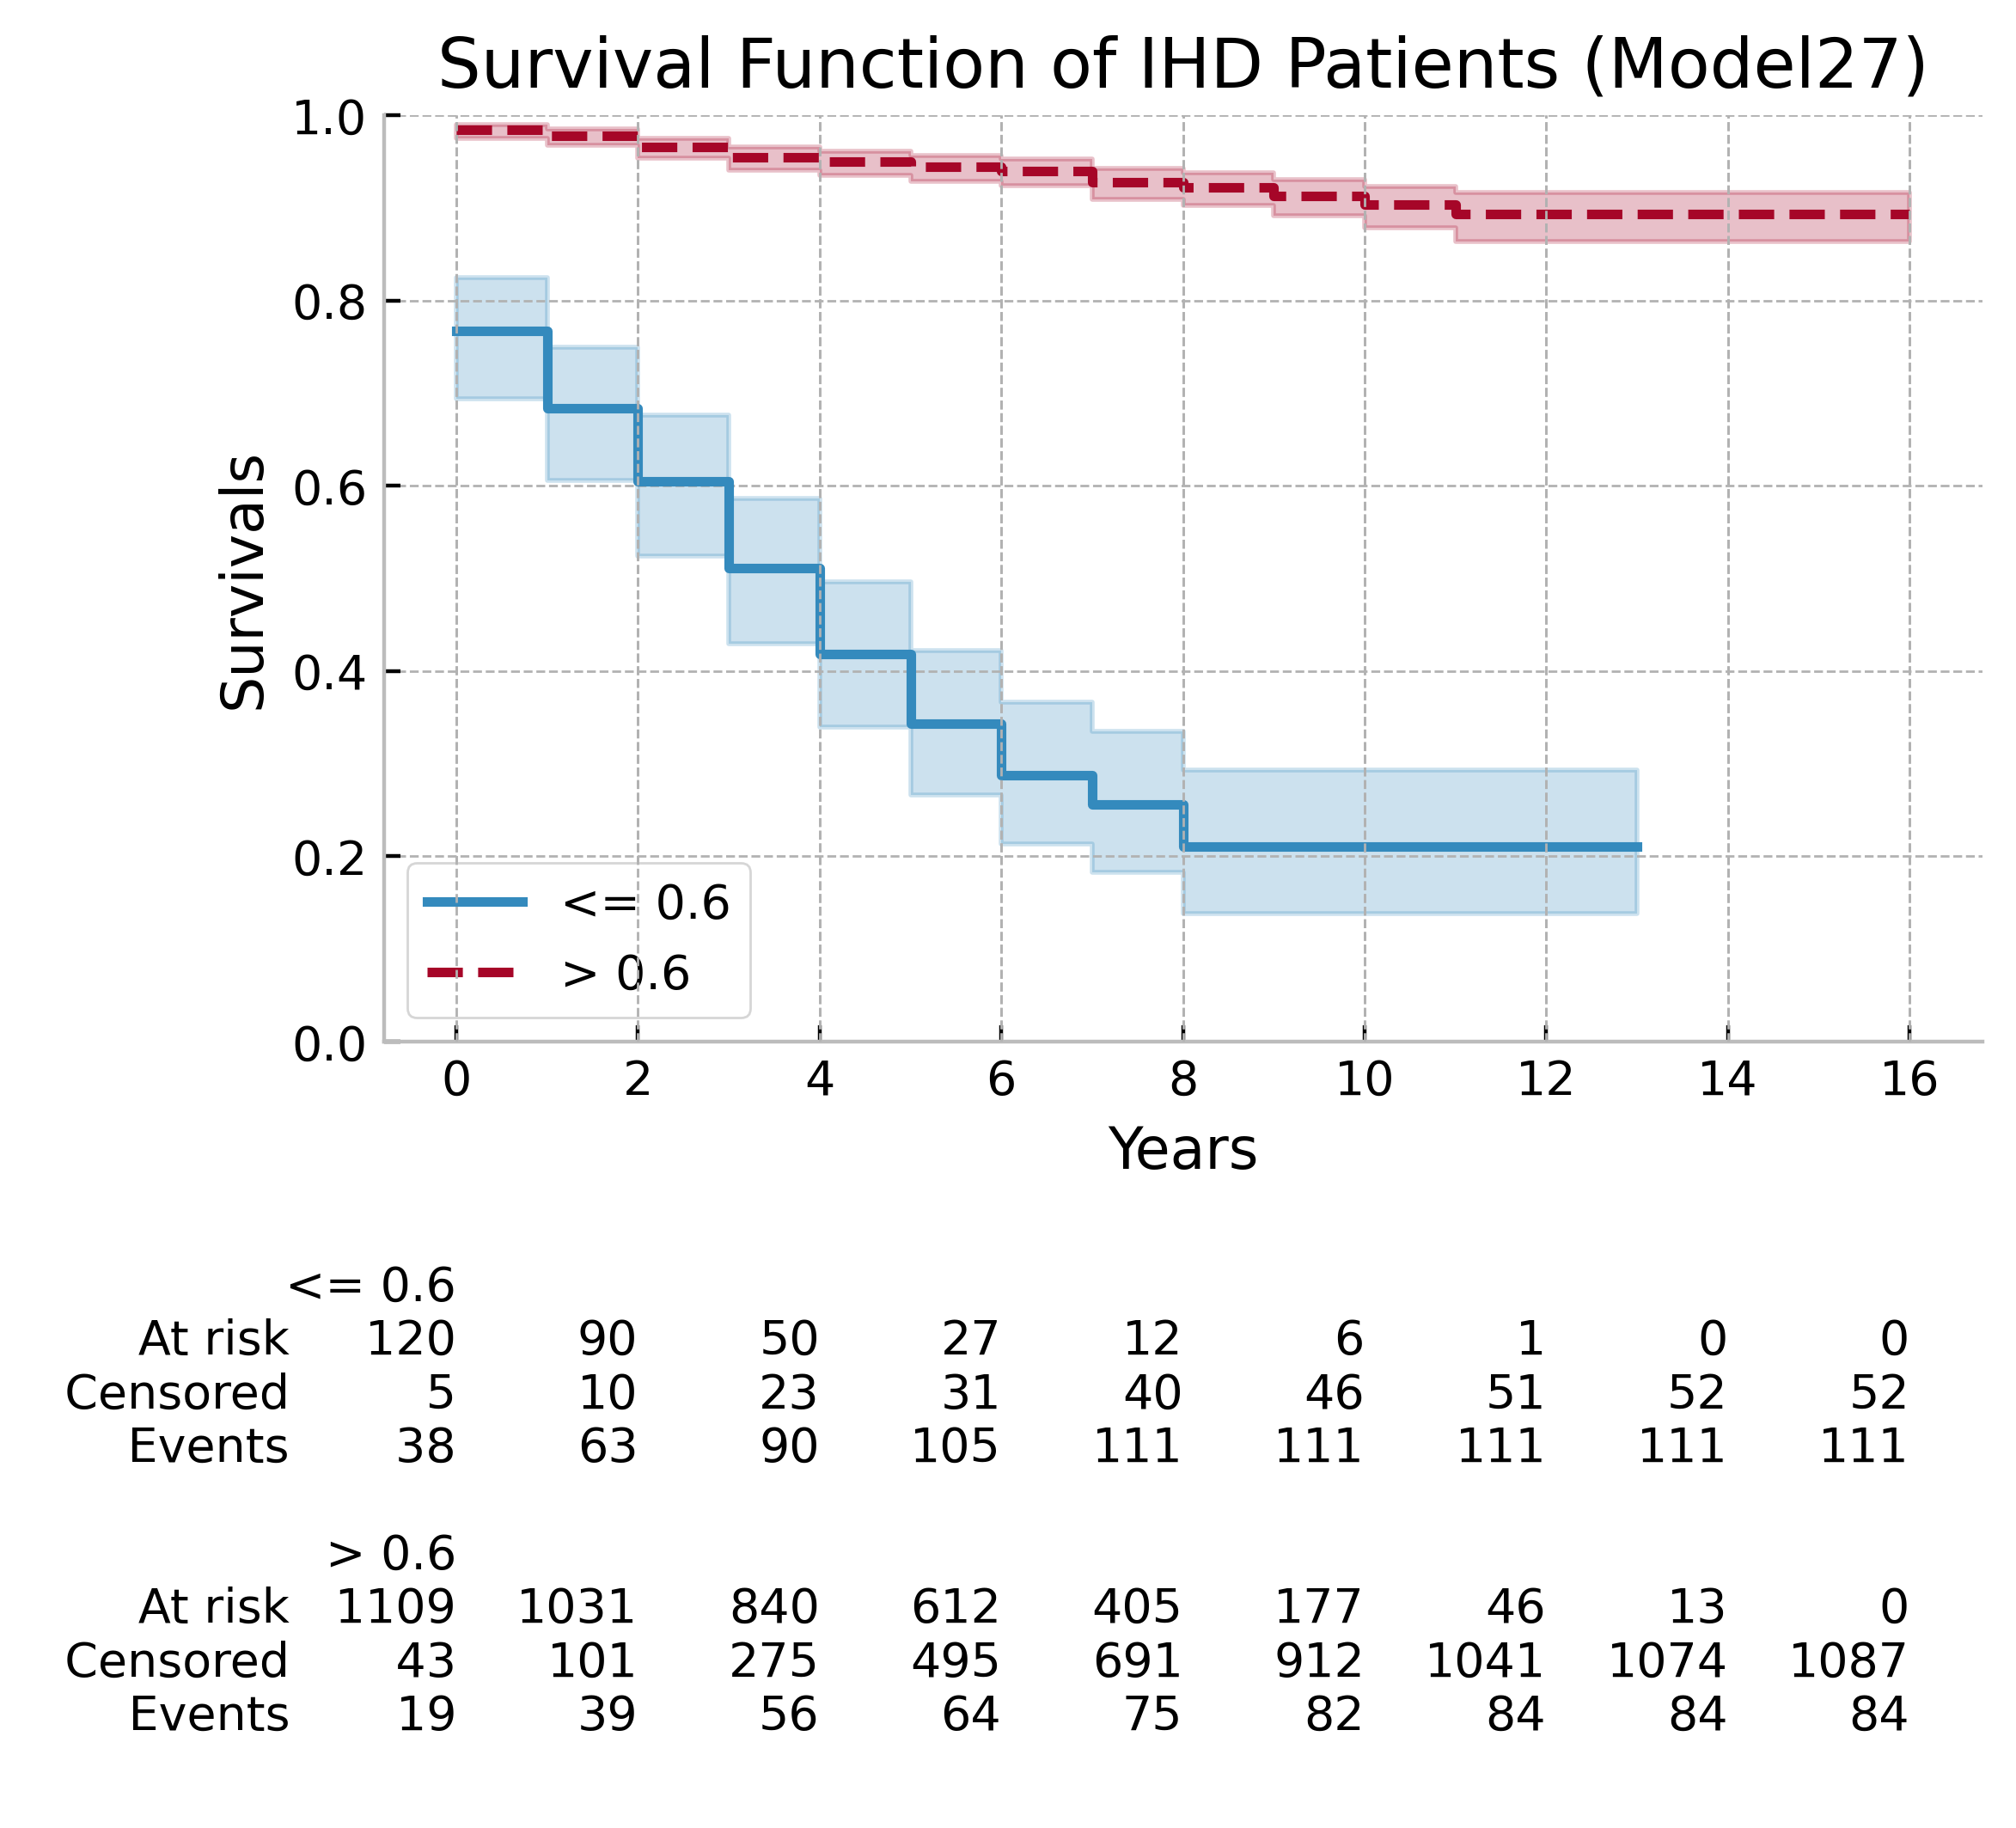

In [20]:
# Plots
fig = plt.figure(figsize=(6, 3.5), dpi=400) 
fig_dims = (1, 1)
fig.subplots_adjust(hspace=1, wspace=0.2)

plt.subplot2grid(fig_dims, (0, 0))
plot_kmf(df_test_pred, threshold=0.6, variable="Model27")
plt.savefig(f"{path_images}survival_model_27.png", bbox_inches="tight", dpi=400)
#plt.savefig(f"{path_images}survival_model_27.tiff", format="tiff", bbox_inches="tight", dpi=400)

## COX Regression and p-value 


In [8]:
df_out = pd.read_csv(f"{path}extra_test_output.csv", index_col=0, decimal='.')

# Model 27 all features
df_test_pred = df.drop(list(set(df.index) - set(df_out.index)))
df_test_pred = df_test_pred.merge(df_out, how="left", left_index=True, right_index=True)


Univariate

In [10]:
i = 17
for key in range(0,27):
    cph = CoxPHFitter()
    cph.fit(df_test_pred.loc[:, [df_test_pred.columns[i], "duration", "observed"]], duration_col='duration', event_col='observed')
    #cph.fit(df_test_pred.loc[:, ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
    print(f"{df_test_pred.columns[key]}: {cph.concordance_index_}")
cph = CoxPHFitter()
cph.fit(df_test_pred.loc[:, ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
print(f"ML Indicator (27 variables): {cph.concordance_index_}")

Gender (Male = 1): 0.5083965767802358
Age: 0.5083965767802358
TSH: 0.5083965767802358
fT3: 0.5083965767802358
fT4: 0.5083965767802358
Euthyroid: 0.5083965767802358
Subclinical primary hypothyroidism (SCH): 0.5083965767802358
Subclinical primary hyperthyroidism
(SCT): 0.5083965767802358
Low T3: 0.5083965767802358
Ipotiroidismo: 0.5083965767802358
Ipertiroidismo: 0.5083965767802358
Angina: 0.5083965767802358
Previous CABG: 0.5083965767802358
Previous PCI: 0.5083965767802358
Previous Myocardial Infarction: 0.5083965767802358
Acute Myocardial Infarction: 0.5083965767802358
Angiography: 0.5083965767802358
Vessels: 0.5083965767802358
Documented resting 
or exertional ischemia: 0.5083965767802358
Post-ischemic Dilated
Cardiomyopathy: 0.5083965767802358
Smoke
History of smoke: 0.5083965767802358
Diabetes
History of diabetes: 0.5083965767802358
Hypertension
History of hypertension: 0.5083965767802358
Dyslipidemia
Hystory of dyslipidemia: 0.5083965767802358
Atrial Fibrillation: 0.508396576780235

Multivariate Top 7 variables

In [12]:
cph = CoxPHFitter()
cph.fit(df_test_pred.loc[:, top + ["duration", "observed"]], duration_col='duration', event_col='observed')
cph.print_summary()

/opt/anaconda3/envs/py385/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 798 total observations, 640 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 798
number of events observed = 158
   partial log-likelihood = -906.41
         time fit was run = 2024-03-25 15:25:42 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
Hyperlipemia\nHistoty of hyperlipemia        -0.96       0.38       0.17            -1.29            -0.62                 0.27                 0.54
FE                                           -0.06       0.94       0.01            -0.08            -0.05                 0.92                 0.95
Previous CABG                                 0.47       1.60       0.19             0.09             0.84                 1.10                 2.32
Diabetes\nHistory of diabetes                 0.46       1.59       0.17             0.12             0.80                 1.13                 2.22
Previous Myocardial Infarction                0.02       1.02       0.18            -0.33             0.38                 0.72                 1.46
Smoke\nHistory of smoke                      -0.33       0.72       0.17            -0.66            -0.01                 0.52                 0.99
Documented resting \nor exertional ischemia   0.05       1.05       0.18            -0.31             0.40                 0.73                 1.50

                                              cmp to     z      p   -log2(p)
covariate                                                                   
Hyperlipemia\nHistoty of hyperlipemia           0.00 -5.55 <0.005      25.04
FE                                              0.00 -9.04 <0.005      62.48
Previous CABG                                   0.00  2.46   0.01       6.16
Diabetes\nHistory of diabetes                   0.00  2.69   0.01       7.12
Previous Myocardial Infarction                  0.00  0.13   0.90       0.15
Smoke\nHistory of smoke                         0.00 -2.02   0.04       4.54
Documented resting \nor exertional ischemia     0.00  0.25   0.80       0.32
---
Concordance = 0.78
Partial AIC = 1826.82
log-likelihood ratio test = 175.03 on 7 df
-log2(p) of ll-ratio test = 111.82

Multivariate Top 7 variables + Model 7

In [13]:
cph = CoxPHFitter()
cph.fit(df_test7_pred.loc[:, top + ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
cph.print_summary()

/opt/anaconda3/envs/py385/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 798 total observations, 640 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 798
number of events observed = 158
   partial log-likelihood = -905.35
         time fit was run = 2024-03-25 15:25:59 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
Hyperlipemia\nHistoty of hyperlipemia        -0.71       0.49       0.24            -1.18            -0.24                 0.31                 0.78
FE                                           -0.04       0.96       0.02            -0.08            -0.01                 0.93                 0.99
Previous CABG                                 0.39       1.47       0.20            -0.00             0.77                 1.00                 2.17
Diabetes\nHistory of diabetes                 0.40       1.49       0.18             0.05             0.74                 1.05                 2.10
Previous Myocardial Infarction               -0.04       0.96       0.19            -0.41             0.32                 0.66                 1.38
Smoke\nHistory of smoke                      -0.14       0.87       0.21            -0.56             0.28                 0.57                 1.32
Documented resting \nor exertional ischemia   0.11       1.12       0.19            -0.26             0.48                 0.77                 1.62
ModelOutput                                  -2.14       0.12       1.46            -4.99             0.72                 0.01                 2.05

                                              cmp to     z      p   -log2(p)
covariate                                                                   
Hyperlipemia\nHistoty of hyperlipemia           0.00 -2.99 <0.005       8.48
FE                                              0.00 -2.49   0.01       6.30
Previous CABG                                   0.00  1.95   0.05       4.28
Diabetes\nHistory of diabetes                   0.00  2.24   0.03       5.31
Previous Myocardial Infarction                  0.00 -0.24   0.81       0.30
Smoke\nHistory of smoke                         0.00 -0.65   0.52       0.95
Documented resting \nor exertional ischemia     0.00  0.61   0.54       0.88
ModelOutput                                     0.00 -1.47   0.14       2.81
---
Concordance = 0.78
Partial AIC = 1826.69
log-likelihood ratio test = 177.16 on 8 df
-log2(p) of ll-ratio test = 110.92

Multivariate Top 7 variables + Model 18

In [14]:
cph = CoxPHFitter()
cph.fit(df_test_pred.loc[:, top + ["ModelOutput", "duration", "observed"]], duration_col='duration', event_col='observed')
cph.print_summary()

/opt/anaconda3/envs/py385/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 798 total observations, 640 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 798
number of events observed = 158
   partial log-likelihood = -874.87
         time fit was run = 2024-03-25 15:26:03 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
Hyperlipemia\nHistoty of hyperlipemia        -0.13       0.88       0.20            -0.52             0.27                 0.59                 1.31
FE                                           -0.01       0.99       0.01            -0.03             0.01                 0.97                 1.01
Previous CABG                                 0.05       1.06       0.20            -0.34             0.44                 0.71                 1.56
Diabetes\nHistory of diabetes                 0.30       1.35       0.17            -0.04             0.64                 0.96                 1.89
Previous Myocardial Infarction               -0.24       0.79       0.19            -0.60             0.13                 0.55                 1.14
Smoke\nHistory of smoke                       0.15       1.16       0.17            -0.19             0.49                 0.83                 1.64
Documented resting \nor exertional ischemia   0.09       1.10       0.18            -0.26             0.44                 0.77                 1.56
ModelOutput                                  -6.76       0.00       0.85            -8.43            -5.09                 0.00                 0.01

                                              cmp to     z      p   -log2(p)
covariate                                                                   
Hyperlipemia\nHistoty of hyperlipemia           0.00 -0.62   0.54       0.90
FE                                              0.00 -0.92   0.36       1.48
Previous CABG                                   0.00  0.27   0.79       0.35
Diabetes\nHistory of diabetes                   0.00  1.74   0.08       3.61
Previous Myocardial Infarction                  0.00 -1.27   0.20       2.30
Smoke\nHistory of smoke                         0.00  0.87   0.38       1.38
Documented resting \nor exertional ischemia     0.00  0.51   0.61       0.71
ModelOutput                                     0.00 -7.92 <0.005      48.59
---
Concordance = 0.82
Partial AIC = 1765.73
log-likelihood ratio test = 238.12 on 8 df
-log2(p) of ll-ratio test = 153.63

Multivariate all variables

In [46]:
df_feat = df_test_pred.drop(columns=["Survive7Y", "Death7Y", "ModelOutput"])
cph = CoxPHFitter()
cph.fit(df_feat, duration_col='duration', event_col='observed')
cph.print_summary()
cph.concordance_index_


/opt/anaconda3/envs/ml_buzi/lib/python3.8/site-packages/lifelines/fitters/coxph_fitter.py:1601: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.661. This may imply non-unique solutions to the maximum likelihood. Perhaps there is collinearity or complete separation in the dataset?

  warnings.warn(
/opt/anaconda3/envs/ml_buzi/lib/python3.8/site-packages/lifelines/utils/printer.py:62: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  return summary_df[columns].to_latex(float_format="%." + str(self.decimals) + "f")


<lifelines.CoxPHFitter: fitted with 1334 total observations, 1139 right-censored observations>
             duration col = 'duration'
                event col = 'observed'
      baseline estimation = breslow
   number of observations = 1334
number of events observed = 195
   partial log-likelihood = -1202.91
         time fit was run = 2024-05-26 20:10:44 UTC

---
                                              coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                           
Gender (Male = 1)                             0.19       1.21       0.17            -0.14             0.52                 0.87                 1.69
Age                                           0.06       1.06       0.01             0.04             0.08                 1.05                 1.08
TSH                                          -0.00       1.00       0.02            -0.04             0.03                 0.97                 1.03
fT3                                          -0.52       0.59       0.17            -0.86            -0.19                 0.42                 0.83
fT4                                           0.01       1.01       0.02            -0.03             0.05                 0.97                 1.05
Euthyroid                                    -4.38       0.01    1118.72         -2197.04          2188.27                 0.00                  inf
Subclinical primary hypothyroidism (SCH)     -3.72       0.02    1118.72         -2196.37          2188.94                 0.00                  inf
Subclinical primary hyperthyroidism\n(SCT)   -4.57       0.01    1118.72         -2197.22          2188.09                 0.00                  inf
Low T3                                       -4.02       0.02    1118.72         -2196.68          2188.64                 0.00                  inf
Ipotiroidismo                                -3.97       0.02    1118.72         -2196.63          2188.68                 0.00                  inf
Ipertiroidismo                               -2.71       0.07    1118.72         -2195.37          2189.95                 0.00                  inf
Angina                                       -0.29       0.75       0.17            -0.62             0.04                 0.54                 1.04
Previous CABG                                 0.16       1.17       0.25            -0.32             0.64                 0.72                 1.91
Previous PCI                                  0.27       1.30       0.23            -0.19             0.73                 0.82                 2.07
Previous Myocardial Infarction                0.03       1.03       0.20            -0.36             0.42                 0.70                 1.52
Acute Myocardial Infarction                  -0.23       0.80       0.29            -0.80             0.34                 0.45                 1.41
Angiography                                  -0.43       0.65       0.20            -0.83            -0.04                 0.44                 0.96
Vessels                                       0.16       1.18       0.09            -0.02             0.35                 0.98                 1.42
Documented resting \nor exertional ischemia  -0.06       0.94       0.19            -0.43             0.31                 0.65                 1.37
Post-ischemic Dilated\nCardiomyopathy         0.30       1.34       0.24            -0.18             0.77                 0.84                 2.16
Smoke\nHistory of smoke                      -0.15       0.86       0.17            -0.48             0.18                 0.62                 1.20
Diabetes\nHistory of diabetes                 0.50       1.65       0.16             0.19             0.82                 1.21                 2.27
Hypertension\nHistory of hypertension        -0.12      

0.8182209630619125